In [6]:
import torch
import time
import sys
import random
import hashlib
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from dataset import DatasetLoader  # Custom dataset module
from transformers import GPT2LMHeadModel, AutoTokenizer, GPT2Config
import asyncio
import logging
import matplotlib.pyplot as plt
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def get_indices(model, seed, compression:int, device:str):
    if compression == 1:
        return {name: torch.arange(param.numel()).long().cpu() for name, param in model.named_parameters()}
    
    seed = int(hashlib.md5(str(seed).encode('utf-8')).hexdigest(), 16) % (2**32)
    rng = np.random.default_rng(seed)
    result = {}
    for name, param in model.named_parameters():
        # Randomly select indices based on the compression factor
        num_indices = max(1, int(param.numel() // compression))
        indices = rng.choice(param.numel(), size=num_indices, replace=False)
        result[name] = torch.from_numpy(indices).long().to(device)
    return result

async def run_sim(base_model, miner_models, optimizers, tokenizer, compression):
    """
    Run a simulation step to compute cosine similarities between miner updates and base model gradients.

    Args:
        base_model (nn.Module): The base model.
        miner_models (list of nn.Module): List of miner models.
        optimizers (list of Optimizer): List of optimizers for the miner models.
        tokenizer (Tokenizer): Tokenizer used for the models.

    Returns:
        similarity (list of float): List of total cosine similarities for each miner model.
    """
    offset = int(time.time())
    similarity = []
    divergence = []
    indices = get_indices(base_model, random.randint(0, 1000), compression=compression, device = base_model.device)
    
    # Compute average.
    averages = {}
    for name, param in base_model.named_parameters():
        idx = indices[name]        
        avg_param = torch.zeros_like(param).view(-1)[idx]
        for miner_model in miner_models:
            miner_param = dict(miner_model.named_parameters())[name]
            avg_param += miner_param.view(-1)[idx]
        avg_param /= len(miner_models)
        averages[name] = avg_param
        
    # Set average in base model.
    for name, param in base_model.named_parameters():
        idx = indices[name].to(param.data.device)
        avg_param = averages[name]
        avg_param = avg_param.to(param.data.dtype)
        avg_param = avg_param.to(param.data.device)
        param.data.view(-1)[ idx ] = avg_param.clone()
        if param.data.view(-1)[ idx ].norm().item() != avg_param.norm().item():
            print(name,avg_param.norm().item(),param.data.view(-1)[ idx ].norm().item(), idx)
            sys.exit()
    
    # Set average in miner models.
    for miner_model in miner_models:
        for name, param in miner_model.named_parameters():
            idx = indices[name]
            avg_param = averages[name]
            avg_param = avg_param.to(param.data.dtype)
            avg_param = avg_param.to(param.data.device)
            param.data.view(-1)[ idx ] = avg_param.clone()

    # Assert that all the values under the indices are the same for base_model and all models
    for name, param in base_model.named_parameters():
        if name not in indices: continue
        base_values = param.view(-1)[indices[name]]
        for miner_model in miner_models:
            # Access miner model parameters directly
            miner_param = dict(miner_model.named_parameters())[name]
            miner_values = miner_param.view(-1)[indices[name]]
            if not torch.allclose(base_values, miner_values, atol=1e-4):
                print(f"Difference for {name}: {base_values - miner_values}")

    # Training phase for miner models
    for i in tqdm(range(len(miner_models)), desc="Training miners"):
        # Each miner trains on its own unique page
        pages = await DatasetLoader.next_pages(
            offset = offset,
            n_pages=1,
            seed=i
        )
        dataset = await DatasetLoader.create(
            batch_size=2,
            sequence_length=1024,
            pages_info=pages,
            tokenizer=tokenizer
        )

        # Zero gradients for the current miner model
        miner_models[i].zero_grad()

        # Train the miner model on its dataset
        for batch in dataset:
            input_ids = torch.tensor(batch, dtype=torch.long).to(miner_models[i].device)
            labels = input_ids.clone()
            labels = torch.where(labels == tokenizer.pad_token_id, -100, labels)

            # Forward pass with mixed precision
            with torch.amp.autocast(device_type=miner_models[i].device.type, dtype=torch.bfloat16):
                outputs = miner_models[i](input_ids=input_ids, labels=labels)
            # Backward pass
            outputs.loss.backward()

        # Update the miner model parameters
        optimizers[i].step()
        optimizers[i].zero_grad()

    # Validation phase: compute similarities
    for i in range(len(miner_models)):
        # Decide whether to use a random page or the same page the miner trained on
        is_random = True if i % 2 != 0 else False
        seed = random.randint(0, 10000) if is_random else i

        # Load validation data
        pages = await DatasetLoader.next_pages(
            offset=offset,
            n_pages=1,
            seed=seed
        )
        dataset = await DatasetLoader.create(
            batch_size=2,
            sequence_length=1024,
            pages_info=pages,
            tokenizer=tokenizer
        )

        # Zero gradients for the base model
        base_model.zero_grad()

        # Compute gradients on the base model
        for batch in dataset:
            input_ids = torch.tensor(batch, dtype=torch.long).to(base_model.device)
            labels = input_ids.clone()
            labels = torch.where(labels == tokenizer.pad_token_id, -100, labels)

            # Forward pass with mixed precision
            with torch.amp.autocast(device_type=base_model.device.type, dtype=torch.bfloat16):
                outputs = base_model(input_ids=input_ids, labels=labels)
            # Backward pass
            outputs.loss.backward()

        # Compute cosine similarity between the miner's update and the base model's gradient
        total_sim = 0.0
        total_divergence = 0.0
        for name, param in base_model.named_parameters():
            if param.grad is None:
                continue  # Skip parameters without gradients
            
            idxs = indices[name].clone().detach().to(base_model.device)

            # Get the gradient from the base model
            g = param.grad.view(-1).clone().detach().to(base_model.device)

            # Get the parameter difference (delta) between the miner model and the base model
            p1 = miner_models[i].state_dict()[name].view(-1).clone().detach().to(base_model.device)
            p2 = param.data.view(-1).clone().detach().to(base_model.device)
            delta = p1 - p2

            # Compute the cosine similarity between delta and gradient
            sim = torch.nn.functional.cosine_similarity(-delta[idxs], g[idxs], dim=0).item()
            weight = p1.data.view(-1)[idxs].norm().item() + 1e-8
            total_sim += weight * sim
            total_divergence += delta[idxs].norm().item()
        
        # Log the similarity result
        logger.info(f'Model {i}, is_random: {is_random}, total_sim: {total_sim}, total_divergence: {total_divergence}')
        similarity.append(total_sim)
        divergence.append( total_divergence )

    # Return the similarities
    return similarity, divergence


In [9]:
async def main(n_steps:int = 2 , n_models: int = 2, device: str = 'cuda:4', compression:int = 1, pretrained: bool = False):
    """
    Main function to run the simulation over multiple steps.
    """
    # Load the base model
    logger.info("Loading base model...")
    if pretrained:
        base_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
    else:
        base_model = GPT2LMHeadModel(config=GPT2Config()).to(device)

    # Load the miner models
    logger.info("Loading miner models...")
    miner_models = [GPT2LMHeadModel(config=GPT2Config()).to(device) for _ in range(n_models)]
    for m in miner_models:
        m.load_state_dict(base_model.state_dict())

    # Create optimizers for miner models
    optimizers = []
    for i in range(n_models):
        optimizers.append(optim.AdamW(
            miner_models[i].parameters(),
            lr=5e-5,  # Peak learning rate
            betas=(0.9, 0.95),  # B1 and B2
            weight_decay=0.1,  # Weight decay
            foreach=True,  # More memory usage, but faster
        ))

    # Load the tokenizer
    logger.info("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained('gpt2', verbose=False, clean_up_tokenization_spaces=True)
    tokenizer.pad_token = tokenizer.eos_token  # Set pad token

    # Run the simulation for multiple steps
    results = []
    div_results = []
    for step in range(n_steps):
        logger.info(f"Starting simulation step {step+1}/{n_steps}...")
        sim, div = await run_sim(base_model, miner_models, optimizers, tokenizer, compression)
        results.append(sim)
        div_results.append(div)

    # After simulation, process and plot the results
    logger.info("Simulation completed. Processing results...")

    # Process similarity results into DataFrame
    df_sim = pd.DataFrame(results, columns=[f'Model_{i}' for i in range(n_models)])
    df_sim['Step'] = range(1, n_steps + 1)
    df_sim = df_sim.set_index('Step')

    # Process divergence results into DataFrame
    df_div = pd.DataFrame(div_results, columns=[f'Model_{i}' for i in range(n_models)])
    df_div['Step'] = range(1, n_steps + 1)
    df_div = df_div.set_index('Step')

    # Add is_random information
    is_random_list = ['Random' if i % 2 != 0 else 'Same' for i in range(n_models)]
    df_sim.columns = pd.MultiIndex.from_tuples(zip(is_random_list, df_sim.columns))
    df_div.columns = pd.MultiIndex.from_tuples(zip(is_random_list, df_div.columns))

    # Plot the similarities and divergences as subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    # Plot the similarities
    for col in df_sim.columns:
        axs[0].plot(df_sim.index, df_sim[col], marker='o', label=f'Model {col[1]} ({col[0]})')
    axs[0].set_xlabel('Simulation Step')
    axs[0].set_ylabel('Total Cosine Similarity')
    axs[0].set_title('Cosine Similarity between Miner Updates and Base Model Gradients')
    axs[0].legend()
    axs[0].grid(True)

    # Plot the divergences
    for col in df_div.columns:
        axs[1].plot(df_div.index, df_div[col], marker='o', label=f'Model {col[1]} ({col[0]})')
    axs[1].set_xlabel('Simulation Step')
    axs[1].set_ylabel('Total Divergence')
    axs[1].set_title('Divergence between Miner Updates and Base Model Parameters')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


INFO:__main__:Loading base model...
INFO:__main__:Loading miner models...
INFO:__main__:Loading tokenizer...
INFO:__main__:Starting simulation step 1/5...
Training miners: 100%|██████████| 2/2 [00:05<00:00,  2.81s/it]
INFO:__main__:Model 0, is_random: False, total_sim: 56.10976594169261, total_divergence: 0.20828833938139724
INFO:__main__:Model 1, is_random: True, total_sim: 47.297156668792695, total_divergence: 0.20829040212265681
INFO:__main__:Starting simulation step 2/5...
Training miners: 100%|██████████| 2/2 [00:05<00:00,  2.54s/it]
INFO:__main__:Model 0, is_random: False, total_sim: 46.17883395636919, total_divergence: 0.14786827864372754
INFO:__main__:Model 1, is_random: True, total_sim: 41.695237465116044, total_divergence: 0.14781085629601876
INFO:__main__:Starting simulation step 3/5...
Training miners: 100%|██████████| 2/2 [00:04<00:00,  2.40s/it]
INFO:__main__:Model 0, is_random: False, total_sim: 41.010975776750996, total_divergence: 0.1225414990376521
INFO:__main__:Model

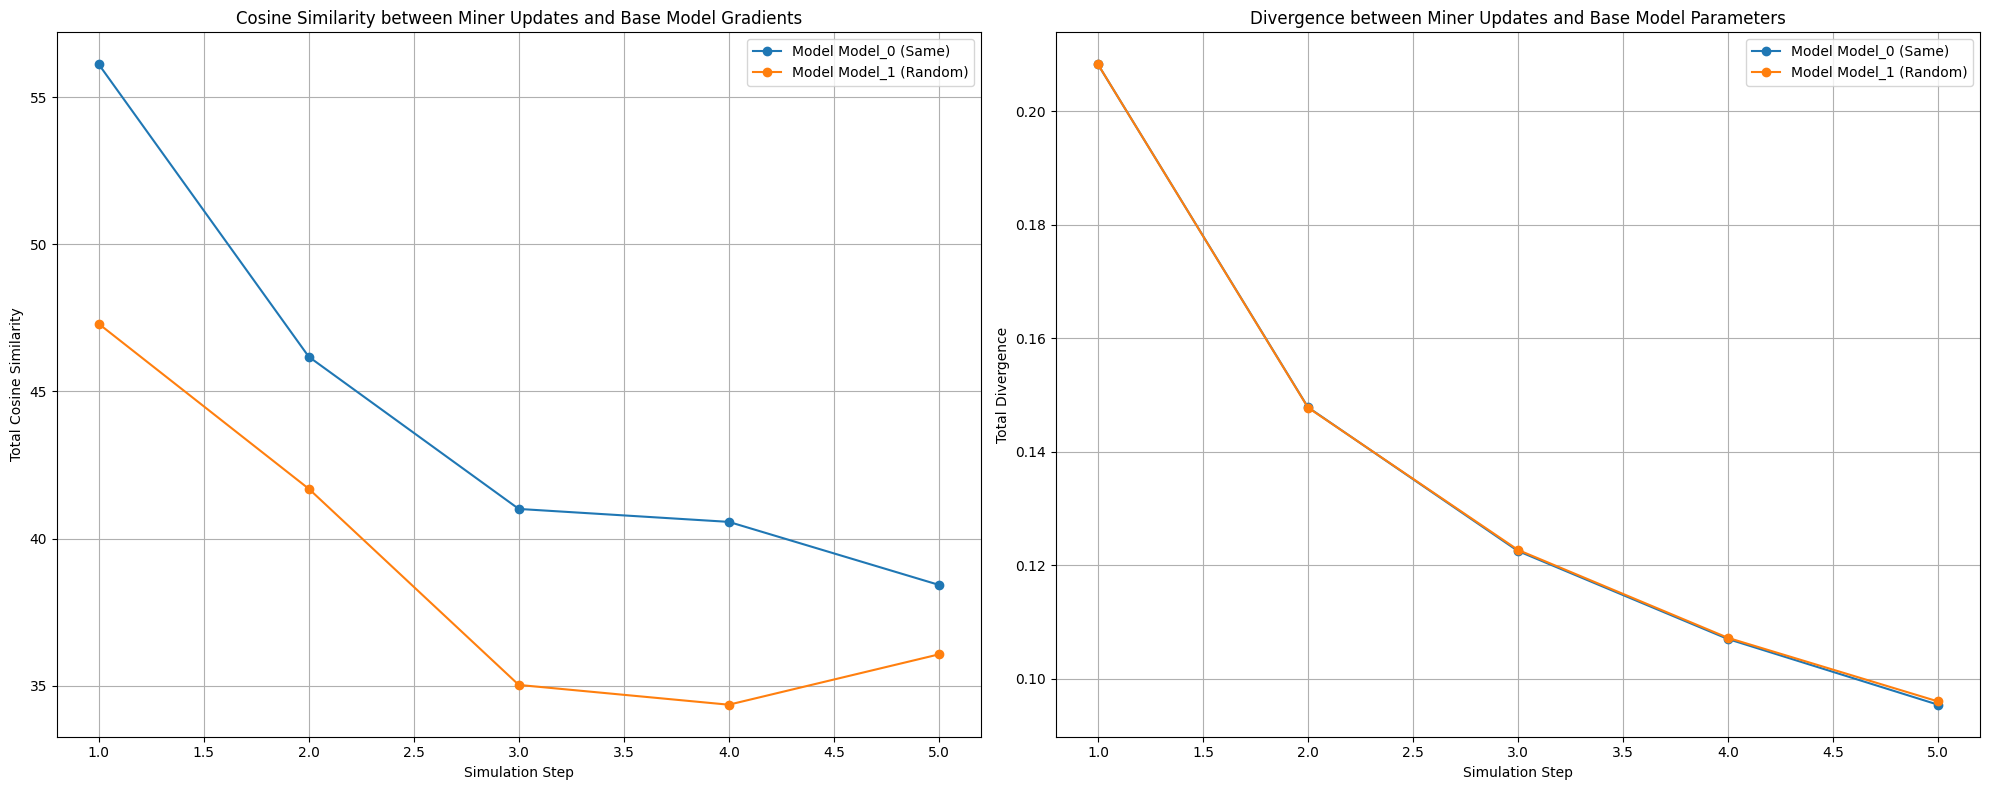

In [10]:
await main( n_steps = 5, n_models = 2, device = 'cuda:4', compression = 300, pretrained = True)